In [2]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")
setwd("/projects/CARDIPS/analysis/epigenome_resource/")

In [3]:
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

In [5]:
basedir="~/projects/Resource/"
bedtools="/frazer01/software/bedtools-2.25.0/bin/bedtools"

### QTL information found in Supplemental Table
filtered_qtls = fread("analyses/tim/ld_modules/scripts/all_qtl_lead_variants.txt",sep="\t",data.table=F)

### New Condition is assigned after QTL filtering and corresponds to discovery order
filtered_qtls$Condition = ifelse(filtered_qtls$new_condition == 0, "Primary",
                                paste("Cond.",filtered_qtls$new_condition))

cvpc_atac_peaks = readRDS("caqtls/CVPC/step_4/qtl_by_element/qtl_input.rds")$phenotype_info

cvpc_chip_peaks = readRDS("haqtls/CVPC/step_4/qtl_by_element/qtl_input.rds")$phenotype_info %>% 
                    filter(element_id %in% filtered_qtls$element_id)

cvpc_atac_peaks$caQTL = ifelse(cvpc_atac_peaks$element_id %in% filtered_qtls$element_id, "TRUE","FALSE")

cvpc_atac_peak_path="~/projects/Resource/notebooks/toGitHub/cvpc_atac_peaks.bed"
cvpc_hapeaks="~/projects/Resource/notebooks/toGitHub/cvpc_hapeaks.bed"
fwrite(cvpc_atac_peaks,cvpc_atac_peak_path,sep="\t",row.names=F,quote=F,col.names=F)
fwrite(cvpc_chip_peaks,cvpc_hapeaks,sep="\t",row.names=F,quote=F,col.names=F)

### Identify overlapping ATAC and ChIP regions
caha_path = paste0(basedir,"notebooks/toGitHub/cvpc_capeak_hapeak.bed")
peak_int_command = paste(bedtools, "intersect", "-a", cvpc_atac_peak_path,
                     "-b", cvpc_hapeaks, "-loj",
                     ">", caha_path)
system(peak_int_command)

caha = fread(caha_path,sep="\t",data.table=F,fill=TRUE)

caha$Annotation = ifelse(caha$V5 == "TRUE" & caha$V10 != ".", "caPeak-haPeak",
                        ifelse(caha$V5 == "TRUE", "caPeak","No QTL"))

cvpc_atac_peaks$Annotation = ifelse(cvpc_atac_peaks$element_id %in% caha$V4[ caha$Annotation == "caPeak-haPeak"], "caPeak-haPeak",
                            ifelse(cvpc_atac_peaks$element_id %in% caha$V4[ caha$Annotation == "caPeak"], "caPeak","non-caPeak"))
table(cvpc_atac_peaks$Annotation)


cvpc_gene_express = readRDS("/projects/CARDIPS/analysis/epigenome_resource/eqtls/CVPC/step_4/qtl_by_element/qtl_input.rds")$phenotype_info
gencode = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)
cvpc_gene_express2 = merge(cvpc_gene_express, gencode[,5:6], by.x="element_id",by.y="gene_id")




       caPeak caPeak-haPeak    non-caPeak 
         8569          2670        191702 

In [4]:
tfbs_path="~/projects/Resource/notebooks/toGitHub/sourcedata/TFBS_Predictions.txt"
tfbs = fread(tfbs_path, sep="\t",data.table=F)

jaspar_tfbs = tfbs %>% filter(Tissue == "CVPC" & Database == "JASPAR") %>% select(MotifID, PeakID,Tissue)

jaspar_tfbs$TFBS = toupper(gsub("_MA.*","",jaspar_tfbs$MotifID))
jaspar_tfbs$occur = 1 

jaspar_expressed = jaspar_tfbs[ jaspar_tfbs$TFBS %in% cvpc_gene_express2$gene_name,]
length(unique(jaspar_expressed$TFBS))

jaspar_cast = reshape2::dcast(PeakID ~ TFBS, data= jaspar_expressed,value.var = "occur",fun.aggregate = sum)
names(cvpc_atac_peaks)[4] = "PeakID"

atac_tfbs = merge(cvpc_atac_peaks, jaspar_cast[ jaspar_cast$PeakID %in% cvpc_atac_peaks$PeakID,], all=TRUE)
atac_tfbs[ is.na(atac_tfbs)] = 0 

property = colnames(atac_tfbs)[7:ncol(atac_tfbs)]
calculate_enrichment = function(property, vertices){
        totest          = vertices[, c(property, "Annotation")]

        colnames(totest) = c("property", "annot")

        annots = names(table(totest$annot))
    
        tests = as.data.frame(rbindlist(lapply(annots, function(annot){
            x11  = nrow(totest[ totest$property == 1 & totest$annot == annot, ])
            x12  = nrow(totest[ totest$property == 1 & totest$annot != annot, ])
            x21  = nrow(totest[ totest$property == 0 & totest$annot == annot, ])
            x22  = nrow(totest[ totest$property == 0 & totest$annot != annot, ])
            mat  = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
            test = fisher.test(mat)
            out  = data.frame(TF = property, Annotation = annot, 
                              x11 = x11, x12 = x12, x21 = x21, x22 = x22, estimate = test$estimate, 
                              ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value)
            return(out)
        })), stringsAsFactors = FALSE)
        return(tests)}

enrich = function(x, annot){
        tests       = as.data.frame(rbindlist(lapply(1:length(property), 
                                                     function(ii){calculate_enrichment(property[ii], x)})))
        tests       = tests
        tests$padj  = p.adjust(tests$pval, method = "BH")
        tests$log2r = log2(tests$estimate)
        return(tests)}


atac_tfbs_enrich = enrich(atac_tfbs[rowSums(data.matrix(atac_tfbs[,7:ncol(atac_tfbs)])) > 0,])


top_tfs = atac_tfbs_enrich[  atac_tfbs_enrich$estimate > 1 & atac_tfbs_enrich$padj < 0.05,] %>% 
                                group_by(Annotation) %>%
                                top_n(10, log2r)

top_tfs = c(top_tfs$TF,"GATA4")

atac_tfbs_enrich2 = atac_tfbs_enrich[ atac_tfbs_enrich$TF %in% top_tfs, ]
atac_tfbs_enrich2$'log2(OR)' = atac_tfbs_enrich2$log2r
atac_tfbs_enrich2$'log2(OR)'[ atac_tfbs_enrich2$'log2(OR)' < -0.75 ] = -0.75
atac_tfbs_enrich2$'log2(OR)'[ atac_tfbs_enrich2$'log2(OR)' > 0.75 ] = 0.75
atac_tfbs_enrich2$Annotation = factor(atac_tfbs_enrich2$Annotation ,
                                      levels = rev(c("caPeak","caPeak-haPeak","non-caPeak")))


atac_tfbs_enrich2_cast = reshape2::dcast(TF ~ Annotation , data = atac_tfbs_enrich2,
                                         fun.aggregate = mean, value.var = "log2(OR)")
rownames(atac_tfbs_enrich2_cast) = atac_tfbs_enrich2_cast$TF
atac_tfbs_enrich2_cast$TF = NULL

ord <- hclust( dist(atac_tfbs_enrich2_cast, method = "euclidean"), method = "ward.D" )$order

atac_tfbs_enrich2$TF2 = factor(atac_tfbs_enrich2$TF, levels = rev(rownames(atac_tfbs_enrich2_cast[ord,])))

atac_tfbs_enrich2$Significance = ifelse(atac_tfbs_enrich2$padj < 0.05, "*", "")



[1] 444

In [5]:
tmp = atac_tfbs[rowSums(data.matrix(atac_tfbs[,7:ncol(atac_tfbs)])) > 0,]
table(tmp$Annotation)


       caPeak caPeak-haPeak    non-caPeak 
         2593          1641         51097 

In [6]:
nrow(tmp)

[1] 55331

In [7]:
atac_tfbs_enrich[ atac_tfbs_enrich$TF == "CTCF",]

,TF,Annotation,x11,x12,x21,x22,estimate,ci1,ci2,pval,padj,log2r
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,CTCF,caPeak,692,13965,1778,36447,1.0157696,0.9270144,1.1120810,7.299041e-01,8.903226e-01,0.02257316
110,CTCF,caPeak-haPeak,232,14425,1361,36864,0.4356344,0.3768876,0.5017757,1.097820e-36,1.462296e-33,-1.19881026
111,CTCF,non-caPeak,13733,924,35086,3139,1.3297341,1.2319403,1.4362579,7.026653e-14,3.021337e-11,0.41113777


In [6]:

# rowSums(data.matrix(atac_tfbs[,7:ncol(atac_tfbs)]))

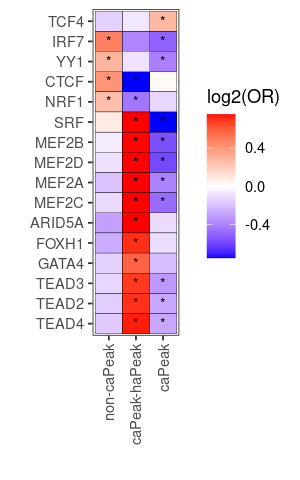

In [8]:
fwrite(atac_tfbs_enrich,"~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE2F.txt",
      sep="\t",row.names=F,quote=F)
psize(4,2.5)
f = ggplot(atac_tfbs_enrich2, aes( Annotation,TF2,  fill= `log2(OR)`)) + theme_bw()+
  geom_tile(color = "black")  +  xlab("") + ylab("") +
    geom_text(aes(label=Significance), color="black", size=3) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
         legend.position ="right") +
  scale_fill_gradient2(low="blue",mid = "white", high="red") 

f